In [1]:
from read_simulation_data.get_foreground_variable import get_foreground_variable
from read_simulation_data.get_background_variable import get_background_variable
from read_simulation_data.get_num_snaps import get_num_snaps
from read_simulation_data.get_info import get_info
import matplotlib.pyplot as plt
from matplotlib.colors import TwoSlopeNorm
import numpy as np
import os
import h5py
import astropy.units as u
from scipy.interpolate import interp1d
from scipy.integrate import cumtrapz

DATA_FOLDER = "/mn/stornext/d10/data/tabjone/data/"
R_SUN = 6.957e10 * u.cm
G = 6.6743e-8 * u.dyne * u.cm**2 / u.g**2

#import seaborn as sns

/usr/lib64/python3.9/site-packages/scipy/__init__.py:138: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.26.1)
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion} is required for this version of "


In [2]:
def read_solar_S_hdf5(file_path):
    with h5py.File(file_path, 'r') as f:
        r_over_R = np.array(f['/r_over_R'])
        c_s = np.array(f['/c_s'])
        Gamma_1 = np.array(f['/Gamma_1'])
        T0 = np.array(f['/T'])
        rho0 = np.array(f['/rho'])
        p0 = np.array(f['/p'])
        
        r_over_R = np.flip(r_over_R)
        c_s = np.flip(c_s)
        Gamma_1 = np.flip(Gamma_1)
        T0 = np.flip(T0) * u.K
        rho0 = np.flip(rho0) * u.g/u.cm**3
        p0 = np.flip(p0) * u.dyne/u.cm**2

        variables = {'r_over_R': r_over_R, 'c_s': c_s, 'Gamma_1': Gamma_1, 'T0': T0, 'rho0': rho0, 'p0': p0}
    return variables

solar_S = read_solar_S_hdf5("../additional_files/solar_s.h5")



In [19]:
def plot_background(DATA_FOLDER, RUN_NAME, SAVE_NAME):
    r, unit = get_background_variable(DATA_FOLDER + RUN_NAME, "r")
    r = r * u.Unit(unit)
    p0, unit = get_background_variable(DATA_FOLDER + RUN_NAME, "p0")
    p0 = p0 * u.Unit(unit)
    rho0, unit = get_background_variable(DATA_FOLDER + RUN_NAME, "rho0")
    rho0 = rho0 * u.Unit(unit)
    T0, unit = get_background_variable(DATA_FOLDER + RUN_NAME, "T0")
    T0 = T0 * u.Unit(unit)
    g, unit = get_background_variable(DATA_FOLDER + RUN_NAME, "g")
    g = g * u.Unit(unit)

    solar_S['M'] = 4*np.pi*R_SUN**3 * cumtrapz(solar_S['rho0']*(solar_S['r_over_R'])**2, solar_S['r_over_R'], initial=0) * u.g /(u.cm**3)
    solar_S['g'] = -G*solar_S['M']/((solar_S['r_over_R']*R_SUN)**2)
    solar_S['g'] = solar_S['g'].to(u.cm/u.s**2)

    Hp = p0 / (rho0 * g)

    solar_S['H'] = -solar_S['p0']/(solar_S['rho0']*solar_S['g'])

    fig, ax = plt.subplots(ncols=3, nrows=2, figsize=(16, 9))

    ax[0][0].plot(solar_S['r_over_R'], solar_S['T0'], color="black", linestyle=":", linewidth=2, label="Solar S")
    ax[0][0].plot(r/R_SUN, T0, color="black", linestyle="--", linewidth=2, label="Our model")
    ax[0][0].set_ylabel("Temperature [K]", fontsize=16)

    ax[0][1].semilogy(solar_S['r_over_R'], solar_S['p0'], color="black", linestyle=":", linewidth=2, label="Solar S")
    ax[0][1].semilogy(r/R_SUN, p0, color="black", linestyle="--", linewidth=2, label="Our model")
    ax[0][1].set_ylabel("Pressure [dyn/cm$^2$]", fontsize=16)

    ax[0][2].semilogy(solar_S['r_over_R'], solar_S['rho0'], color="black", linestyle=":", linewidth=2, label="Solar S")
    ax[0][2].semilogy(r/R_SUN, rho0, color="black", linestyle="--", linewidth=2, label="Our model")
    ax[0][2].set_ylabel("Density [g/cm$^3$]", fontsize=16)

    ax[1][0].plot(solar_S['r_over_R'], np.abs(solar_S['g']).to("cm s-2"), color="black", linestyle=":", linewidth=2, label="Solar S")
    ax[1][0].plot(r/R_SUN, g.to("cm s-2"), color="black", linestyle="--", linewidth=2, label="Our model")
    ax[1][0].set_ylabel("Gravitational acceleration [cm s$^{-2}$]", fontsize=16)

    l1, = ax[1][1].semilogy(solar_S['r_over_R'], solar_S['H'].to("cm"), color="black", linestyle=":", linewidth=2, label="Solar S")
    l2, = ax[1][1].semilogy(r/R_SUN, Hp.to("cm"), color="black", linestyle="--", linewidth=2, label="Our model")
    ax[1][1].set_ylabel("Pressure scale height [cm]", fontsize=16)

    lines = [l1, l2]
    labels = [l1.get_label(), l2.get_label()]

    #ax[2, 1].set_facecolor('white')
    #ax[2, 1].axis('off')

    for i in [0,1]:
        for j in [0,1,2]:
            if i == 2 and j == 1:
                pass
            else:
                ax[i,j].tick_params(axis='both', labelsize=14)
                #ax[i,j].legend(fontsize=14, loc="lower left")
                ax[i,j].set_xlim(0.6, 1.0)
                #axis.set_xlabel("Radius [Solar radii]", fontsize=16)
                #axis.yaxis.set_major_formatter(formatter)
                #ax[i,j].grid(True, which="both", ls="-", color='0.65')

    ax[0][0].set_ylim(0, 0.4e7)
    ax[0][1].set_ylim(1e6, 1e16)
    ax[0][2].set_ylim(1e-6, 1e0)
    ax[1][0].set_ylim(1e4, 1e5)
    ax[1][1].set_ylim(1e8, 1e10)

    ax[1][1].set_xlabel("Radius [Solar radii]", fontsize=16)
    ax[1][0].set_xlabel("Radius [Solar radii]", fontsize=16)
    ax[1][2].set_xlabel("Radius [Solar radii]", fontsize=16)

        # Draw the face (a large circle)
    face = plt.Circle((0.5, 0.5), 0.4, color='yellow', ec='black', lw=2)
    ax[1][2].add_patch(face)

    # Draw the eyes (two smaller circles)
    left_eye = plt.Circle((0.35, 0.65), 0.05, color='black')
    right_eye = plt.Circle((0.65, 0.65), 0.05, color='black')
    ax[1][2].add_patch(left_eye)
    ax[1][2].add_patch(right_eye)

    # Draw the mouth (an arc)
    theta = np.linspace(0, np.pi, 100)
    x = 0.5 - 0.2 * np.cos(theta)
    y = 0.4 - 0.1 * np.sin(theta)
    ax[1][2].plot(x, y, color='black', lw=2)
    ax[1][2].set_xlim(0,1)

    # Set the aspect of the plot to be equal
    ax[1][2].set_aspect('equal')

    fig.legend(lines, labels, loc='lower center', ncol=2, fontsize=14)

    fig.tight_layout(rect=[0, 0.05, 1, 1])

    plt.savefig(SAVE_NAME)

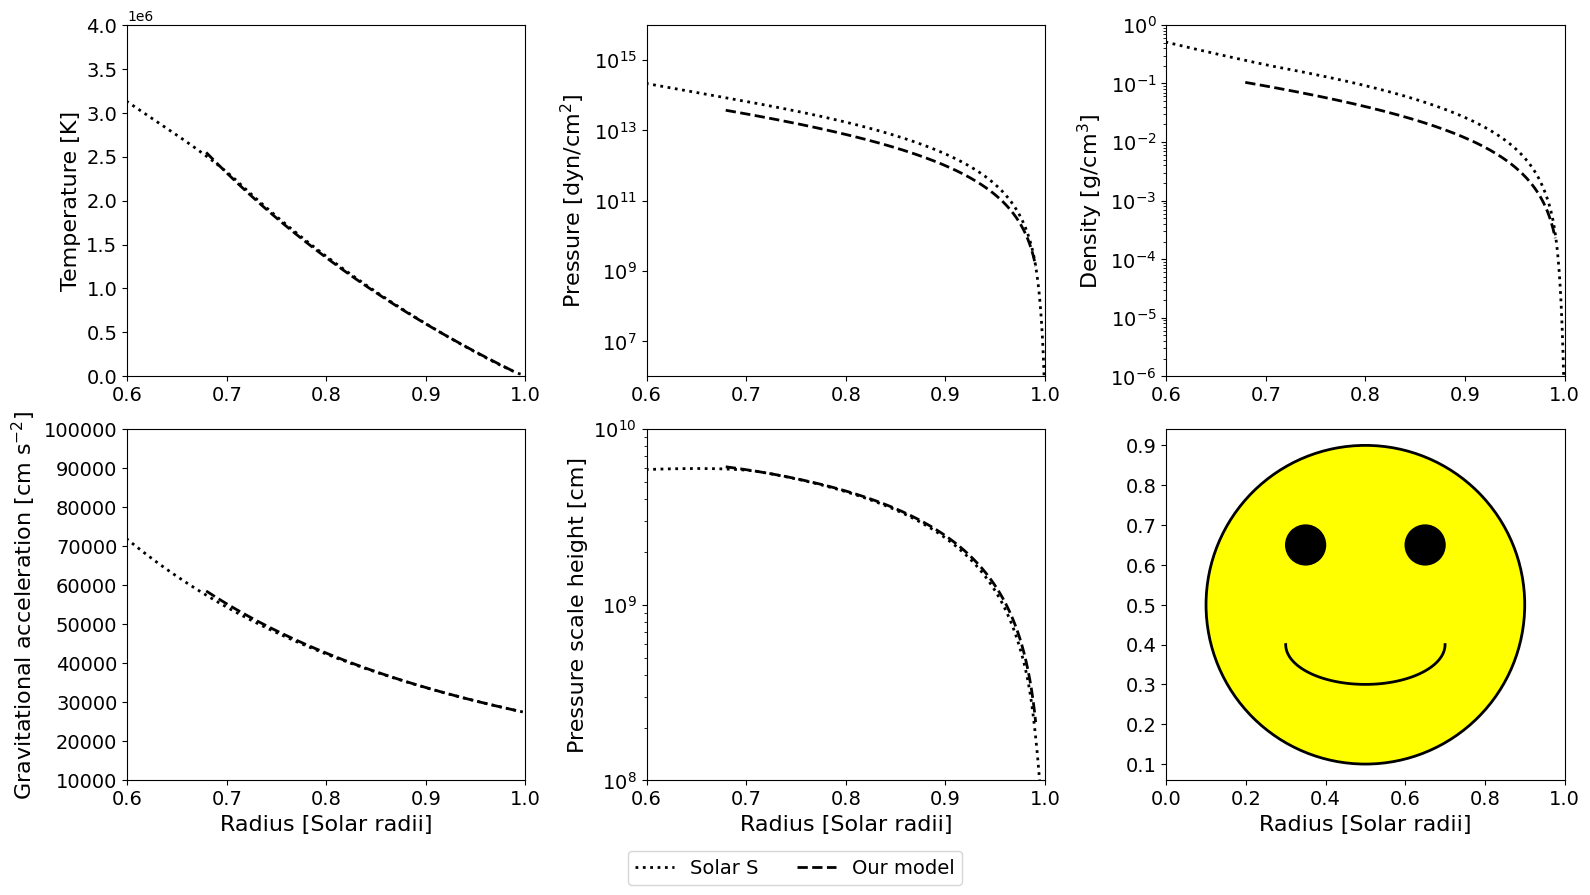

In [20]:
RUN_NAME = "test_other_ic_4/"

plot_background(DATA_FOLDER, RUN_NAME, "./data/background.png")